# CNN on MNIST

In this notebook, we train one of oldest CNNs, called [_LeNet_](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), to classify hand-written digits from 0 to 9. The dataset is public and called [_MNIST_](http://yann.lecun.com/exdb/mnist/). MNIST is widely used for an introductory machine learning (ML) courses/lectures, and not limited to CNN. LeNet is one of the very first CNN application and nearly 2 decades old, and first applied on MNIST.

First we go over MNIST data set, LeNet construction, and finally training.

In [1]:
from __future__ import print_function
import torch
import numpy as np

## MNIST data set
Most, if not all, ML libraries provide an easy way (API) to access MNIST dataset. This is true in `pytorch` as well. MNIST dataset in `Dataset` instance is available from `torchvision`. 

In [2]:
from torchvision import datasets, transforms

LOCAL_DATA_DIR = './data' # this is where data files are downloaded

dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))
print(len(dataset),'images prepared!')

60000 images prepared!


Let's visualize data with a label.

Label: 5


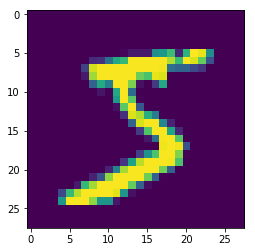

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# Print label
print('Label:',dataset[0][1])
# Draw data
plt.imshow(dataset[0][0].view([28,28]))
plt.show()

Next, let's crate `DataLoader` for training. If you have not learned what `DataLoader` is, [read this notebook](https://github.com/watchmal/ExampleNotebooks/blob/master/HKML%20DataLoader.ipynb).

In [4]:
train_loader = torch.utils.data.DataLoader(dataset,batch_size=20,shuffle=True,num_workers=1,pin_memory=True)

## Defining a network
In `pytorch`, a network is defined as a `torch.Module` inherited class. In this class, we define the network architecture as well as a _forward_ function to process input image data and perform a digit classification task.

LeNet has 2 convolution layers, each followed by rectified linear unit (ReLU) and max-pooling, for feature extractions. Then the extracted features run through two hidden layers multi-layer perceptron (MLP) at the end for classifying the input image data into digits (0 to 9).

In [5]:
class LeNet(torch.nn.Module):
    def __init__(self):
        
        super(LeNet, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,6,5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(6,16,5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2) )
        # classifier MLP
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(256,120),
            torch.nn.ReLU(),
            torch.nn.Linear(120,84),
            torch.nn.ReLU(),
            torch.nn.Linear(84,10) )

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classify and return
        return self._classifier(features)

## Defining a train loop
For convenience, define a _BLOB_ class to keep objects together. To a BLOB instance, we attach LeNet, our loss function (`nn.CrossEntropyLoss`), and Adam optimizer algorithm. For analysis purpose, we also include `nn.Softmax`. Finally, we attach data and label place holders.

In [6]:
class BLOB:
    pass
blob=BLOB()
blob.net       = LeNet().cuda() # construct Lenet, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.iteration = 0    # integer count for the number of train steps
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

We define 2 functions to be called in the training loop: _forward_ and _backward_. These functions implement the evaluation of the results, error (loss) definition, and propagation of errors (gradients) back to update the network parameters. The name "backward" is because the computation starts from the error (=end result of forward) and proceed toward the input (=start of forward).

In [7]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = blob.data.cuda()
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = blob.label.cuda() #label = torch.stack([ torch.as_tensor(l) for l in np.hstack(label) ])
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())        
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()


Now we are ready for training! Let's write a loop to load data, call forward, and call backward.

In [8]:
# Set the network to training mode
blob.net.train()

# Let's train 2000 steps
stop_iteration = 2000
# Loop over data samples and into the network forward function
for i,data in enumerate(train_loader):
    blob.iteration = i
    # data and label
    blob.data, blob.label = data
    # call forward
    res = forward(blob,True)
    # once in a while, report
    if blob.iteration == 0 or (blob.iteration+1)%100 == 0:
        print('Iteration',blob.iteration,'... Loss',res['loss'],'... Accuracy',res['accuracy'])
    if (blob.iteration+1)==stop_iteration:
        break
    backward(blob)
    

Iteration 0 ... Loss 2.3122355938 ... Accuracy 0.05
Iteration 99 ... Loss 0.346674442291 ... Accuracy 0.9
Iteration 199 ... Loss 0.497713625431 ... Accuracy 0.8
Iteration 299 ... Loss 0.241645216942 ... Accuracy 0.9
Iteration 399 ... Loss 0.250156462193 ... Accuracy 0.95
Iteration 499 ... Loss 0.244063779712 ... Accuracy 0.95
Iteration 599 ... Loss 0.519220530987 ... Accuracy 0.85
Iteration 699 ... Loss 0.0337696075439 ... Accuracy 1.0
Iteration 799 ... Loss 0.0939548015594 ... Accuracy 1.0
Iteration 899 ... Loss 0.0888887867332 ... Accuracy 0.95
Iteration 999 ... Loss 0.0660198703408 ... Accuracy 1.0
Iteration 1099 ... Loss 0.0137215014547 ... Accuracy 1.0
Iteration 1199 ... Loss 0.329166710377 ... Accuracy 0.95
Iteration 1299 ... Loss 0.0213056094944 ... Accuracy 1.0
Iteration 1399 ... Loss 0.77374869585 ... Accuracy 0.9
Iteration 1499 ... Loss 0.119014680386 ... Accuracy 0.95
Iteration 1599 ... Loss 0.0418060198426 ... Accuracy 1.0
Iteration 1699 ... Loss 0.246302723885 ... Accuracy

It's very important to validate basic facts. At the very beginning, the network's guess should be random (accuracy ~0.1). The accuracy should be indicated in the step of 0.05 since our batch size is 20. This training shows anything strange but successful.

## Saving & Restoring the states
After spending some time and money for computing the network weights, it's a good idea to learn how to save the state so that you can come back and restart the training from where you were, or use it for analysis. We define two functions for saving and restoring the weights.

In [9]:
def save_state(blob, prefix='./snapshot'):
    # Output file name
    filename = '%s-%d.ckpt' % (prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(weight_file, blob):
    # Open a file in read-binary mode
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.iteration = checkpoint['global_step']

Let's save the current state:

In [10]:
weight_file = save_state(blob)

Next, for a demonstration, we'll reset the network by creating a new instance. Let's also make sure that the network performance should go back to a random guess.

In [11]:
# Recreate the network (i.e. initialize)
blob.net=LeNet().cuda()
# Get one batch of data to test
blob.data, blob.label = next(iter(train_loader))
# Run forward function
res = forward(blob,True)
# Report
print('Accuracy:',res['accuracy'])


Accuracy: 0.1


As expected, the accuracy is close to a random guess (0.1). Next, let's load the saved state and check the accuracy on the same data.

In [12]:
# Restore the state
restore_state(weight_file,blob)
# Run the forward function
res = forward(blob,True)
# Report
print('Accuracy',res['accuracy'])

Accuracy 0.85


We successfully loaded the saved weights.

## Evaluation
When we use a supervised training technique on a train dataset, we often worry about _over training_, which means some features learned by the network is specific to the train set and not useful in general. In order to make sure what was learned during the training stays relevant, we should test the network's performance on a statistically independent dataset, called _test sample_ (or loosely _validation sample_).

We define a function that runs inference and returns an accuracy (per batch), label (per image), and prediction (per image)

In [13]:
def overall_accuracy(blob,train=False):
    # load the test dataset
    dataset = datasets.MNIST(LOCAL_DATA_DIR, train=train, download=True,
                             transform=transforms.Compose([transforms.ToTensor()]))
    # create DataLoader
    test_loader = torch.utils.data.DataLoader(dataset,batch_size=40,shuffle=False,num_workers=2,pin_memory=True)
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    accuracy, label, prediction = [], [], []
    confusion_matrix = np.zeros([10,10],dtype=np.int32)
    for i,data in enumerate(test_loader):
        blob.data, blob.label = data
        res = forward(blob,True)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
    # organize the return values
    accuracy   = np.hstack(accuracy)
    prediction = np.hstack(prediction)
    label      = np.hstack(label)
    return accuracy, label, prediction

Let's run the inference for both train and test datasets.

Train set accuracy mean 0.9697166666666666 std 0.028003030589959763


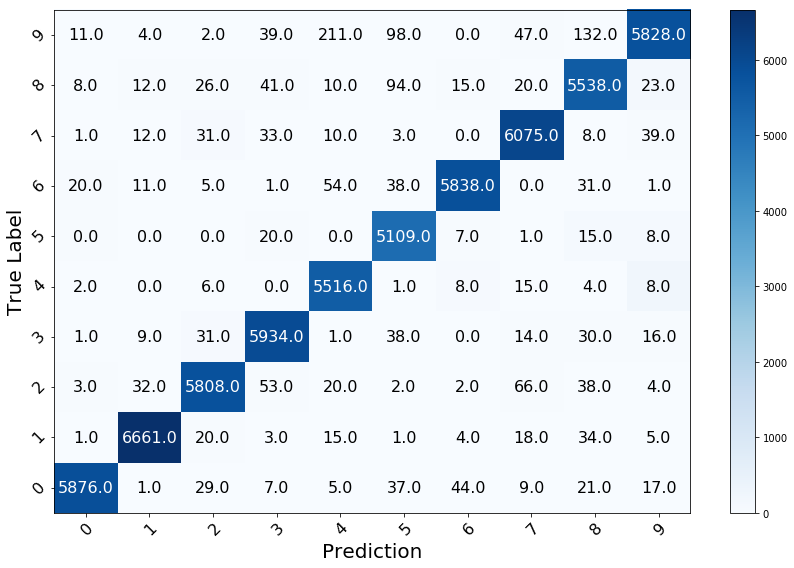

Test set accuracy mean 0.9719 std 0.030624989795916664


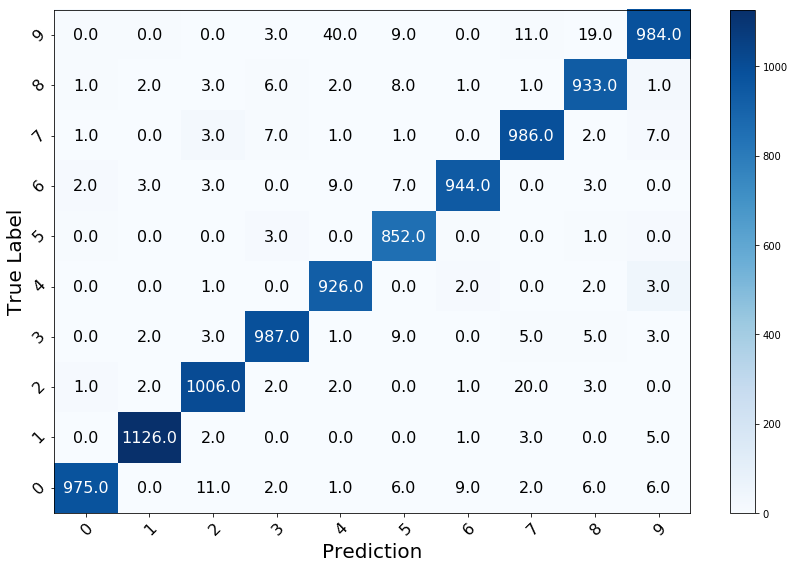

In [14]:
# For plotting a confusion matrix
%matplotlib inline
from utils import plot_confusion_matrix

# For the Train set
accuracy, label, prediction = overall_accuracy(blob,True)
print("Train set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[str(d) for d in range(10)])

# For the Test set
accuracy, label, prediction = overall_accuracy(blob,False)
print("Test set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[str(d) for d in range(10)])


The results look quite similar between the train and test datasets (note the overall normalization is different). This suggests there was no overtraining in this exercise :)